## Process data by joining everything together

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import os
import geopandas as gpd
from scipy.stats import pearsonr
import pykrige

import statsmodels.api as sm


from scipy.stats import spearmanr, kendalltau
import pandas as pd
from pyproj import Transformer
from scipy.spatial import distance
import numpy as np


In [ ]:
# join the four datasets together
NO2 = pd.read_csv("Data/AirQuality/NO2.csv")
PM10 = pd.read_csv("Data/AirQuality/PM10.csv")
PM25 = pd.read_csv("Data/AirQuality/PM25.csv")
SO2 = pd.read_csv("Data/AirQuality/SO2.csv")



In [83]:
# change the column names to be the same
NO2.columns = ['Measurement' if col == "NO2 (ug/m3)" else col for col in NO2.columns]
PM10.columns = ['Measurement' if col == "PM10 (ug/m3)" else col for col in PM10.columns]
PM25.columns = ['Measurement' if col == "PM25 (ug/m3)" else col for col in NO2.columns]
SO2.columns = ['Measurement' if col == "SO2 (ug/m3)" else col for col in NO2.columns]

In [103]:
NO2['SpeciesType'] = 'NO2'
PM10['SpeciesType'] = 'PM10'
PM25['SpeciesType'] = 'PM25'
SO2['SpeciesType'] = 'SO2'

In [104]:
AQ_combined = pd.concat([NO2, PM10, PM25, SO2])
AQ_combined.sample(5)

,MeasurementDateGMT,Measurement,SiteCode,LocalAuthorityCode,LocalAuthorityName,SiteName,SiteType,DateOpened,DateClosed,Latitude,Longitude,SpeciesType
39975,2018-01-30 21:00,130.7,CD9,6,Camden,Camden - Euston Road,Roadside,2011-01-29 00:00:00,2020-07-02 00:00:00,51.527975,-0.128774,NO2
144198,2018-02-20 12:00,27.9,NM2,25,Newham,Newham - Cam Road,Roadside,1998-08-18 00:00:00,NaN,51.537598,-0.002138,NO2
34050,2018-02-23 03:00,23.3,BX2,3,Bexley,Bexley - Belvedere,Suburban,1998-01-24 15:00:00,NaN,51.490610,0.158914,PM10
20194,2018-01-17 01:00,5.0,WA9,32,Wandsworth,Wandsworth - Putney,Urban Background,2011-01-04 00:00:00,NaN,51.465033,-0.215825,PM10
140061,2018-02-28 05:00,13.6,BQ8,3,Bexley,Bexley - Belvedere West FDMS,Urban Background,2010-08-24 00:00:00,2022-02-23 00:00:00,51.494649,0.137279,PM10


In [86]:
AQ_combined.to_csv("Data/AirQuality/AQ_combined.csv", index=False)

pair the sites

In [87]:
# read the congestion data for their coordinates
CS_coor = pd.read_csv("Data/CongestionScoot/Metadata(siteCoordinates.csv")
CS_coor.sample(5)

transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)

# transform the coordinates to lat and long
CS_coor['Longitude'], CS_coor['Latitude'] = zip(*CS_coor.apply(lambda x: transformer.transform(x['Easting'], x['Northing']), axis=1))

In [20]:
CS_coor.sample(5)

,ID,Easting,Northing,Longitude,Latitude
1111,05-296,535027,182214,-0.055095,51.522710
3936,30-123,528007,191500,-0.152845,51.607795
1250,06-183,539554,178911,0.008808,51.491930
1075,05-210,534803,182705,-0.058134,51.527176
3939,30-133,528273,191190,-0.149120,51.604949


In [88]:
# calculate the distance between the air quality monitoring stations and the congestion monitoring stations

dist_matrix = distance.cdist(AQ_combined[['Latitude', 'Longitude']], CS_coor[['Latitude', 'Longitude']], 'euclidean')

min_dist_indices = np.argmin(dist_matrix, axis=1)
# 
closest_ids = pd.Series(CS_coor['ID'].iloc[min_dist_indices].values)
# add the closest congestion monitoring station to the air quality monitoring station
AQ_combined['ID'] = closest_ids
# save the combined dataset
AQ_combined.to_csv("Data/AirQuality/AQ_combined.csv", index=False)

In [70]:
# read the combined dataset
AQ_combined = pd.read_csv("Data/AirQuality/AQ_combined.csv")

In [90]:
# get the unique congestion monitoring station ids
CS_ids = AQ_combined['ID'].unique()

CS_ids

array(['20-140', '07-268', '28-027', '20-261', '01-329', '10-037',
       '09-076', '20-139', '07-034', '14-004', '27-102', '06-266',
       '20-017', '08-177', '10-136', '00-042', '17-258', '01-083',
       '02-144', '18-064', '32-071', '18-103', '09-081', '19-092',
       '10-264', '26-151', '16-139', '27-271', '03-080', '21-024',
       '29-006', '06-016', '06-010', '10-070', '01-241', '09-253',
       '07-143', '31-027', '28-124', '15-006', '14-099', '01-103',
       '02-052', '15-114', '06-053', '10-254', '32-002', '02-045',
       '31-002', '32-083', '06-191', '06-299', '10-125', '21-020',
       '24-146', '04-125', '24-132', '02-122', '28-193', '05-107',
       '27-255', '01-379', '06-265', '23-057', '06-067', '32-205',
       '17-197', '03-112', '20-307', '22-033', '15-007', '05-098',
       '00-083', '29-035', '28-149', '00-028', '08-038', '06-066',
       '26-068', '06-033', '24-092', '12-065'], dtype=object)

In [91]:
CS_data_merged = pd.DataFrame()
# merge all the congestion data together based on the list of IDs

for CS_id in CS_ids:
    filename = f"{CS_id}.csv"
    CS_data = pd.read_csv(f"Data/CongestionScoot/MergedCSVs/{filename}")

    CS_data['ID'] = CS_id
    # merge the Date and Time columns into a single column


    # 将Date和Time列合并为一个字符串列
    CS_data['DateTimeStr'] = CS_data['Date'] + ' ' + CS_data['Time']

    # 将合并后的字符串转换为datetime格式，并创建一个新列
    CS_data['MeasurementDateGMT'] = pd.to_datetime(CS_data['DateTimeStr'], format='%d-%b-%Y %H:%M')

    # 如果你想要将datetime列的格式化输出为'yyyy-mm-dd HH:MM'样式，可以这样做
    # 注意：这一步实际上会将列转换回字符串格式，所以如果你需要保留datetime对象，可以跳过这一步
    CS_data['MeasurementDateGMT'] = CS_data['MeasurementDateGMT'].dt.strftime('%Y-%m-%d %H:%M')

    CS_data_merged = pd.concat([CS_data_merged, CS_data])
        


In [ ]:
# merge the air quality and congestion data together
AQ_CS_All = pd.merge(AQ_combined, CS_data_merged, left_on=['ID', 'MeasurementDateGMT'], right_on=['ID', 'MeasurementDateGMT'], how='left')
AQ_CS_All.to_csv("Data/AirQuality/AQ_CS_All.csv", index=False)

In [97]:
# read the weather data
Weather = pd.read_csv("Data/weather_cleaned.csv")

In [100]:
# merge the weather data with the air quality and congestion data

Weather['MeasurementDateGMT'] = Weather['date']
Weather.sample(15)

AQ_CS_All_all = pd.merge(AQ_CS_All, Weather, left_on=['MeasurementDateGMT'], right_on=['MeasurementDateGMT'], how='left')

In [102]:
# save the final dataset
AQ_CS_All_all.to_csv("Data/AQ_CS_All.csv", index=False)

#### visualize the data after merging

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import os
import geopandas as gpd
from scipy.stats import pearsonr
import pykrige

import statsmodels.api as sm


from scipy.stats import spearmanr, kendalltau

In [3]:
AQ_CS_All_all = pd.read_csv("Data/AQ_CS_All_Full.csv")

C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)
C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


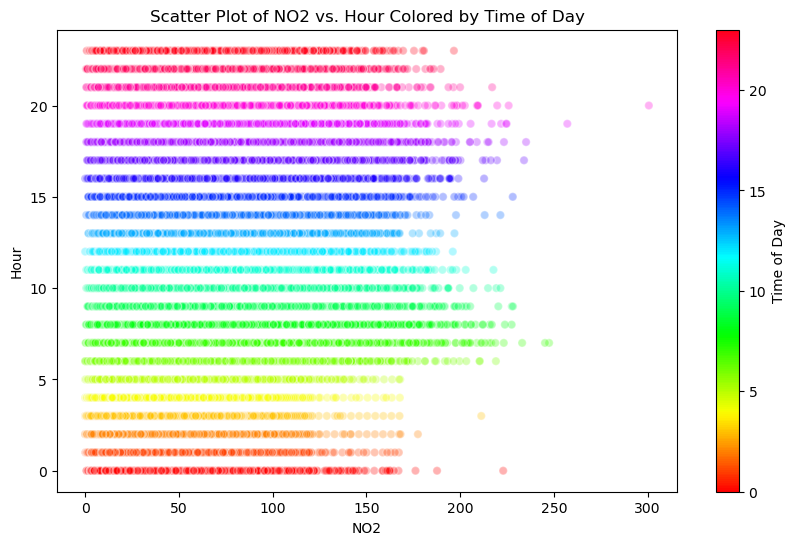

C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)
C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


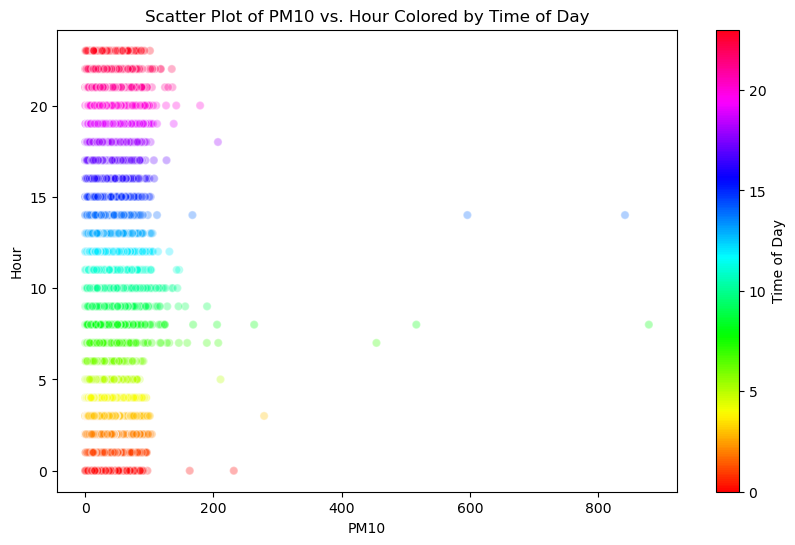

C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)
C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


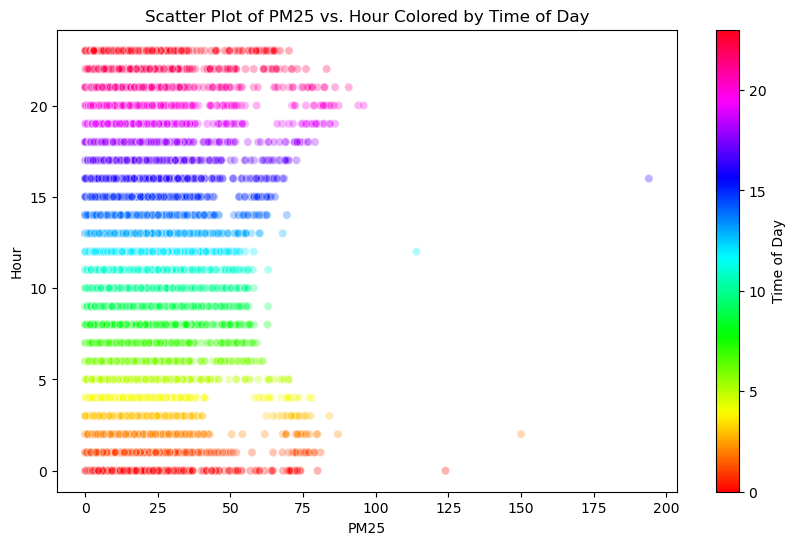

C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)
C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\1195647376.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


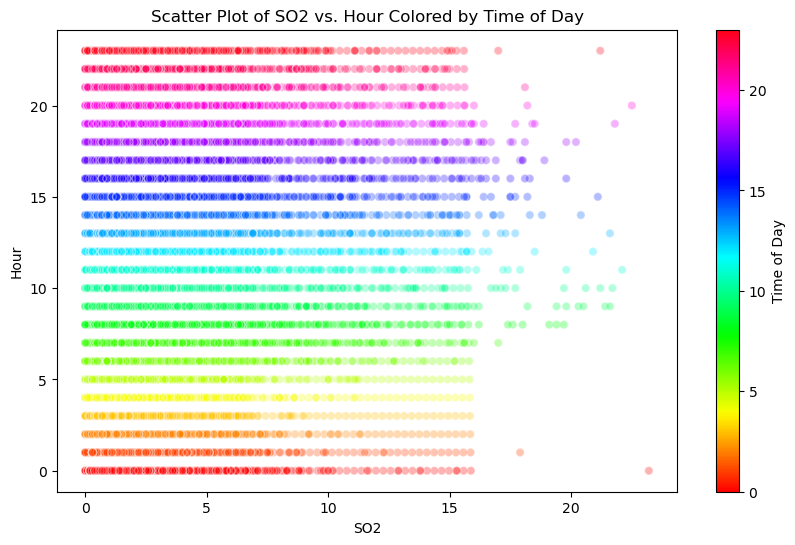

In [8]:
#----------------------scatter plot----------------------
for Species_code in AQ_CS_All_all['SpeciesType'].unique():

    AQ_CS_subset = AQ_CS_All_all[AQ_CS_All_all['SpeciesType'] == Species_code]


    AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)

    norm = colors.Normalize(vmin=0, vmax=23)

    # 接下来，创建一个颜色映射对象
    cmap = cm.ScalarMappable(norm=norm, cmap='hsv')

    plt.figure(figsize=(10, 6))
    plt.scatter(x='Measurement',
                y='Hour',
                c=cmap.to_rgba(AQ_CS_subset['Hour']),  # 使用颜色映射对象为数据点着色
                data=AQ_CS_subset,
                alpha=0.3,  
                edgecolors='w')  

    # 添加色带
    cbar = plt.colorbar(cmap)
    cbar.set_label('Time of Day')

    plt.xlabel(f'{Species_code}')
    plt.ylabel('Hour')
    plt.title(f'Scatter Plot of {Species_code} vs. Hour Colored by Time of Day')
    plt.show()

In [5]:
AQ_CS_All_all.columns

Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')

C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\549141610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)
C:\Users\SBH\AppData\Local\Temp\ipykernel_28268\549141610.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


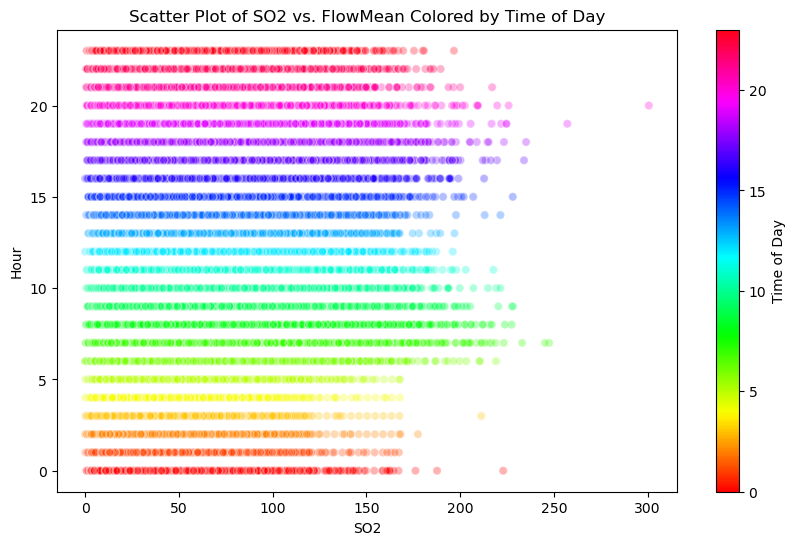

In [6]:
AQ_CS_subset = AQ_CS_All_all[AQ_CS_All_all['SpeciesType'] == "NO2"]


AQ_CS_subset['Hour'] = AQ_CS_subset['Time'].str.split(':').str[0].astype(float)

norm = colors.Normalize(vmin=0, vmax=23)

# 接下来，创建一个颜色映射对象
cmap = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.figure(figsize=(10, 6))
plt.scatter(x='Measurement',
            y='Hour',
            c=cmap.to_rgba(AQ_CS_subset['Hour']),  # 使用颜色映射对象为数据点着色
            data=AQ_CS_subset,
            alpha=0.3,  
            edgecolors='w')  

# 添加色带
cbar = plt.colorbar(cmap)
cbar.set_label('Time of Day')

plt.xlabel(f'SO2')
plt.ylabel('Hour')
plt.title(f'Scatter Plot of SO2 vs. FlowMean Colored by Time of Day')
plt.show()

## calculate the distance between the sites

In [108]:
CS_XY = pd.read_csv("Data/CongestionScoot/Metadata(siteCoordinates.csv")

CS_XY['Longitude'], CS_XY['Latitude'] = zip(*CS_XY.apply(lambda x: transformer.transform(x['Easting'], x['Northing']), axis=1))

QA_XY = pd.read_csv("Data/AirQuality/MonitoringSites.csv")

In [111]:
dist_matrix2 = distance.cdist(QA_XY[['Latitude', 'Longitude']], CS_XY[['Latitude', 'Longitude']], 'euclidean')

DF_dist_matrix2 = pd.DataFrame(dist_matrix2, index=QA_XY['SiteCode'], columns=CS_XY['ID'])

## calculate the correlation between the air quality and the congestion

#### after checking the map(html), the ID=02-064 and ID=02-144 are close to the air quality site SiteCode=CD9
#### so import those three datasets and analyze the correlation between the air quality and the congestion

In [3]:
AQ_CS_All = pd.read_csv("Data/AQ_CS_All.csv")
AQ_CS_All.columns


Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')

In [4]:
print(AQ_CS_All['Measurement'].isna().sum())
print(AQ_CS_All['SatMean'].isna().sum())
print(AQ_CS_All['FlowMean'].isna().sum())
print((AQ_CS_All['Measurement'] < 0).sum())
print((AQ_CS_All['SatMean'] < 0).sum())
print((AQ_CS_All['FlowMean'] < 0).sum())

39151
5708
5708
1793
30240
0


In [5]:
AQ_CS_All['Measurement'] = AQ_CS_All['Measurement'].mask(AQ_CS_All['Measurement'] < 0, np.nan)
AQ_CS_All['SatMean'] = AQ_CS_All['SatMean'].mask(AQ_CS_All['SatMean'] < 0, np.nan)
AQ_CS_All['FlowMean'] = AQ_CS_All['FlowMean'].mask(AQ_CS_All['FlowMean'] < 0, np.nan)

In [6]:
print(AQ_CS_All['Measurement'].isna().sum())
print(AQ_CS_All['SatMean'].isna().sum())
print(AQ_CS_All['FlowMean'].isna().sum())
print((AQ_CS_All['Measurement'] < 0).sum())
print((AQ_CS_All['SatMean'] < 0).sum())
print((AQ_CS_All['FlowMean'] < 0).sum())

40944
35948
5708
0
0
0


In [7]:
AQ_CS_All['Measurement'] = AQ_CS_All['Measurement'].interpolate(method='linear')
AQ_CS_All['SatMean'] = AQ_CS_All['SatMean'].interpolate(method='linear')
AQ_CS_All['FlowMean'] = AQ_CS_All['FlowMean'].interpolate(method='linear')


In [8]:
AQ_CS_All['Measurement'] = AQ_CS_All['Measurement'].interpolate(method='spline',order=1)
AQ_CS_All['SatMean'] = AQ_CS_All['SatMean'].interpolate(method='spline',order=1)
AQ_CS_All['FlowMean'] = AQ_CS_All['FlowMean'].interpolate(method='spline',order=1)


In [9]:
print(AQ_CS_All['Measurement'].isna().sum())
print(AQ_CS_All['SatMean'].isna().sum())
print(AQ_CS_All['FlowMean'].isna().sum())
print((AQ_CS_All['Measurement'] < 0).sum())
print((AQ_CS_All['SatMean'] < 0).sum())
print((AQ_CS_All['FlowMean'] < 0).sum())

0
0
0
0
0
0


In [10]:
AQ_CS_All.to_csv("Data/AQ_CS_All_Full.csv", index=False)